In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from datetime import datetime
import numpy as np
import matplotlib as mpl
import re
from fastai.tabular import *

In [221]:
df_m = pd.read_csv("Meld_trends.csv", header=0)
df_m.head()

,Date,Place,Ill,Trends_grypa
0,2010-12-16,dolnośląskie,1528,954.888073
1,2010-12-08,dolnośląskie,2222,1006.751990
2,2010-12-01,dolnośląskie,2082,733.428257
3,2010-11-23,dolnośląskie,2230,801.065877
4,2010-11-16,dolnośląskie,1795,815.985721


In [222]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [223]:
add_datepart(df_m, "Date", drop=False)

In [224]:
df_m.head()

,Date,Place,Ill,Trends_grypa,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2010-12-16,dolnośląskie,1528,954.888073,2010,12,50,16,3,350,False,False,False,False,False,False,1292457600
1,2010-12-08,dolnośląskie,2222,1006.751990,2010,12,49,8,2,342,False,False,False,False,False,False,1291766400
2,2010-12-01,dolnośląskie,2082,733.428257,2010,12,48,1,2,335,False,True,False,False,False,False,1291161600
3,2010-11-23,dolnośląskie,2230,801.065877,2010,11,47,23,1,327,False,False,False,False,False,False,1290470400
4,2010-11-16,dolnośląskie,1795,815.985721,2010,11,46,16,1,320,False,False,False,False,False,False,1289865600


In [225]:
df_m = df_m.sort_values(by="Date")
df_m = df_m.replace({'-': 1})
# df_m[df_m.Date=="2010-12-16"]

In [226]:
df_m.Ill = df_m.Ill.astype('float')
type(df_m.Ill.iloc[0])

numpy.float64

In [227]:
df_m[df_m.Trends_grypa=="0"]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,Date,Place,Ill,Trends_grypa,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed


In [228]:
df_train = df_m.iloc[:6900]
df_test = df_m.iloc[6900:]
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

#'Place', 
cat_vars =  ['Dayofyear',  'Year', 'Month', 'Day']
cont_vars = ['Trends_grypa']
#              "TempDob", "TempDob_last7"] 

dep_var = 'Ill'
df = df_train[cat_vars + cont_vars + [dep_var,'Date']].copy()
procs=[FillMissing, Categorify, Normalize]

cut = df_train['Date'][(df_train['Date'] == df_train['Date'][len(df_test)])].index.max()
valid_idx = range(cut-2)
cut
valid_idx

range(0, 797)

In [229]:
df_test['Date'].min(), df_test['Date'].max()

(Timestamp('2019-01-08 00:00:00'), Timestamp('2020-01-16 00:00:00'))

In [230]:
data = (TabularList.from_df(df, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
        .split_by_idx(valid_idx)      
        .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
        .add_test(TabularList.from_df(df_test, cat_names=cat_vars, cont_names=cont_vars))
        .databunch())

In [231]:
max_log_y = np.log(np.max(df_train['Ill'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [232]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(89, 20)
    (1): Embedding(10, 6)
    (2): Embedding(13, 7)
    (3): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=38, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [233]:
len(data.train_ds.cont_names)

1

In [234]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


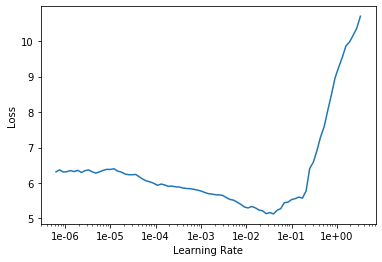

In [235]:
learn.recorder.plot()

In [210]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,4.092679,4.207615,114.169754,00:32
1,2.491951,5.217436,139.524796,00:33
2,2.138379,5.640341,195.685516,00:32
3,1.945316,5.860415,189.011826,00:32
4,1.898466,5.779897,193.253510,00:30


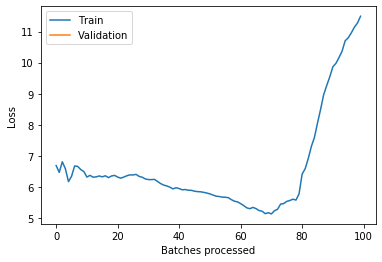

In [236]:
learn.recorder.plot_losses(skip_start=0)

In [237]:
test_preds=learn.get_preds(DatasetType.Test)
test_preds
df_test["Ill_ex"]=np.exp(test_preds[0].data).numpy().T[0]
# test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
# test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)

In [238]:
df_test

,Date,Place,Ill,Trends_grypa,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,Ill_ex
0,2019-01-08,podkarpackie,3825.0,997.750568,2019,1,2,8,1,8,False,False,False,False,False,False,1546905600,263.145630
1,2019-01-08,małopolskie,16309.0,997.750568,2019,1,2,8,1,8,False,False,False,False,False,False,1546905600,263.145630
2,2019-01-08,warmińsko-mazurskie,2313.0,997.750568,2019,1,2,8,1,8,False,False,False,False,False,False,1546905600,263.145630
3,2019-01-08,dolnośląskie,7177.0,997.750568,2019,1,2,8,1,8,False,False,False,False,False,False,1546905600,263.145630
4,2019-01-08,zachodniopomorskie,2221.0,997.750568,2019,1,2,8,1,8,False,False,False,False,False,False,1546905600,263.145630
5,2019-01-08,lubelskie,5782.0,997.750568,2019,1,2,8,1,8,False,False,False,False,False,False,1546905600,263.145630
6,2019-01-08,opolskie,2199.0,997.750568,2019,1,2,8,1,8,False,False,False,False,False,False,1546905600,263.145630
7,2019-01-08,lubuskie,1383.0,997.750568,2019,1,2,8,1,8,False,False,False,False,False,False,1546905600,263.145630
8,2019-01-08,świętokrzyskie,2269.0,997.750568,2019,1,2,8,1,8,False,False,False,False,False,False,1546905600,263.145630
9,2019-01-08,kujawsko-pomorskie,7260.0,997.750568,2019,1,2,8,1,8,False,False,False,False,False,False,1546905600,263.145630
